In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi

Mon Feb 24 20:58:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:01:00.0 Off |                  Off |
| 49%   71C    P2             95W /  230W |    1602MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os

if 'notebooks' in os.getcwd():
    os.chdir("..")

import evaluate
from datasets import load_dataset, Dataset
from huggingface_hub import notebook_login
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import time
import csv
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from trl import SFTTrainer, SFTConfig
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported
from unsloth.chat_templates import train_on_responses_only, get_chat_template
import aiohttp
import asyncio
from tqdm.asyncio import tqdm
import torch
import scienceplots
plt.style.use(['science', 'no-latex'])
from IPython.display import clear_output
from src.pytorch_utils import count_parameters
from src.text_utils import trim_text_to_token_limit
from src.train_test_split import stratified_train_test_split
from unsloth import FastLanguageModel


tqdm.pandas()

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [4]:
notebook_login()

In [5]:
torch.cuda.set_per_process_memory_fraction(0.6, device=0)


# Supervised Fine Tuning (SFT)

In this notebook we will finetune our Small Language Model on the target completions

## Loading base model

In [6]:
max_seq_length = 6000
dtype = None 
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen2-0.5B-Instruct", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    cache_dir = '/Data'
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2025.2.15: Fast Qwen2 patching. Transformers: 4.49.0.
   \\   /|    GPU: NVIDIA RTX A5000. Max memory: 23.651 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


## Using LoRA adapters

In [7]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, 
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.2.15 patched 24 layers with 24 QKV layers, 24 O layers and 24 MLP layers.


In [8]:
count_parameters(model)

Total Parameters: 323,917,696 
Trainable Parameters: 8,798,208 (3.0 %)


## Loading dataset

In [9]:
base_data = pd.read_json("data/wikipedia_dataset.json")
completions_df = pd.read_pickle("data/generated_dataset_100_Meta-Llama-3.1-8B-Instruct-bnb-4bit_2.pkl")

In [10]:
text_df = pd.merge(
    base_data,
    completions_df,
    on = 'id'
)[['id', 'text', 'num_tokens', 'generated_text']]

In [11]:
text_df.head()

,id,text,num_tokens,generated_text
0,9513,"Conhecimento (do latim cognoscere, ""ato de con...",1785,"O conhecimento é o ato ou efeito de conhecer, ..."
1,1337,"O nazismo (), oficialmente nacional-socialismo...",2864,O nazismo é uma ideologia associada a Adolf Hi...
2,1718,Sergipe é uma das 27 unidades federativas do B...,3041,Sergipe é um estado brasileiro localizado na R...
3,3832,Suíça ( ; em suíço-alemão: Schwyz ou Schwiiz ;...,674,A Suíça é uma república federal composta por 2...
4,302,"Aristóteles (; Estagira, – Atenas, ) foi um f...",2666,Aristóteles foi um filósofo e polímata da Gréc...


### Train test split

We will perform a stratified train-test split, maintaining the distribution of number of tokens     

In [12]:
train_df , temp = stratified_train_test_split(text_df, test_size=0.4)
test_df, val_df = stratified_train_test_split(temp, test_size=0.5)

Text(0.5, 0, 'Number of tokens')

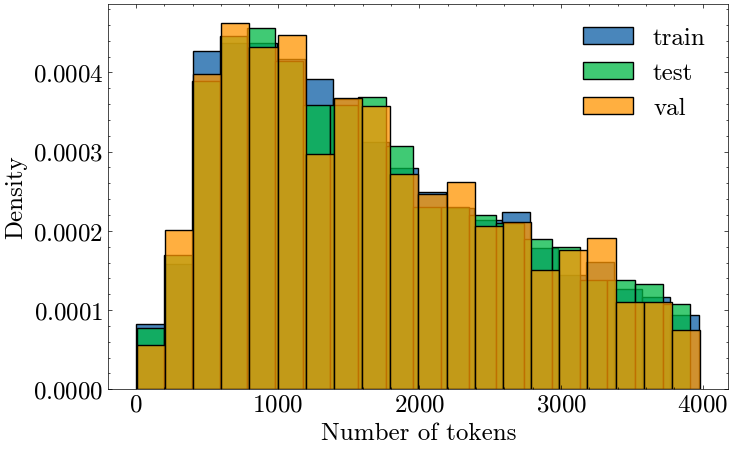

In [13]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = (8,5))

sns.histplot(train_df, x = 'num_tokens', stat = 'density', bins = 20, label = 'train')
sns.histplot(test_df, x = 'num_tokens', stat='density', bins = 20, label = 'test')
sns.histplot(val_df, x = 'num_tokens', stat='density', bins = 20, label = 'val')
plt.legend()
plt.xlabel("Number of tokens")

## Finetuning

In [14]:
from datasets import Dataset

In [15]:
n_words = 100

In [16]:
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "qwen-2.5",
)

def format_row(row):
    prompt = f'''
        Você é um assistente virtual que deve gerar resumos de textos em português. 
        Seu resumo deve ter, no máximo {n_words} palavras e conter todas as informações principais do texto.
        Esse é o texto:

        {row['text']}
        
        Faça um resumo de no máximo {n_words} palavras do texto acima.
    '''

    row['conversations'] = [{'role': 'user', "content": prompt}, {'role': 'assistant', 'content': row['generated_text']}]
    return row


def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }

def generate_and_tokenize_prompt(text):
    # Generate the full prompt with the assistant's response
    tokenized_full_prompt = tokenizer(text, return_tensors='pt')

    # Clone the input_ids to create labels
    labels = tokenized_full_prompt.input_ids.clone()

    # Find the position of "<assistant>" in the prompt
    prompt_text = text[:text.find(">assistant")] + ">assistant"
    end_prompt_idx = len(tokenizer(prompt_text, return_tensors="pt")["input_ids"][0])

    # Mask all tokens before "<assistant>" with -100
    labels[:, :end_prompt_idx] = -100

    return {
        'input_ids': tokenized_full_prompt.input_ids.flatten(),
        'labels': labels.flatten(),
        'attention_mask': tokenized_full_prompt.attention_mask.flatten(),
    }

def preprocess_df(df):
    temp_df = df.progress_apply(format_row, axis =1)
    temp_df = formatting_prompts_func(temp_df)

    tokens = []
    for t in tqdm(temp_df['text']):
        tokens.append(generate_and_tokenize_prompt(t))

    
    tokens_dataset = Dataset.from_list(tokens)
    return tokens_dataset

In [17]:
train_dataset = preprocess_df(train_df)
val_dataset = preprocess_df(val_df)
test_dataset = preprocess_df(test_df)

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:06<00:00, 145.38it/s]


In [18]:
train_dataset

Dataset({
    features: ['input_ids', 'labels', 'attention_mask'],
    num_rows: 3000
})

In [20]:
trainer = SFTTrainer(
    model = model,
    train_dataset = train_dataset,
    eval_dataset= val_dataset,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    # compute_metrics = compute_metrics,
    args = SFTConfig(
        # eval_strategy = 'steps',
        # eval_steps = 1,
        per_device_train_batch_size = 16,
        gradient_accumulation_steps = 4,
        dataset_num_proc = 2,
        packing = False, # Can make training 5x faster for short sequences.
        warmup_steps = 5,
        num_train_epochs = 1, # Set this for 1 full training run.
        learning_rate = 2e-5,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        hub_model_id= "peulsilva/slm-pt",
        save_total_limit=1,
        # output_dir = "/Data",
        # report_to = "none", # Use this for WandB etc,
        # push_to_hub=True,
        # save_steps = 10,
        # hub_strategy="every_save",
        max_seq_length = max_seq_length,
        # dataset_text_field = 'text',
        batch_eval_metrics = True,
        # padding = True,
    ),
)



In [21]:
n_epochs = 5
for epoch in range(n_epochs):
    trainer.train()
    trainer.model.push_to_hub_merged(f"peulsilva/qwen-0.5b-instruct-summary-pt-checkpoint{epoch}")
    trainer.tokenizer.push_to_hub(f"peulsilva/qwen-0.5b-instruct-summary-pt-checkpoint{epoch}")

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 3,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 16 | Gradient Accumulation steps = 4
\        /    Total batch size = 64 | Total steps = 47
 "-____-"     Number of trainable parameters = 8,798,208


Step,Training Loss
1,1.103000
2,1.128900
3,1.129700
4,1.139900
5,1.074800
6,1.156500
7,1.122500
8,1.090200
9,1.091500
10,1.031100


Unsloth: You're not saving a tokenizer as well?
You can do it separately via `tokenizer.push_to_hub(...)`
Unsloth: You are pushing to hub, but you passed your HF username = peulsilva.
We shall truncate peulsilva/qwen-0.5b-instruct-summary-pt-checkpoint0 to qwen-0.5b-instruct-summary-pt-checkpoint0


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 25.62 out of 62.29 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 24/24 [00:00<00:00, 137.10it/s]


README.md:   0%|          | 0.00/594 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Done.
Saved merged model to https://huggingface.co/peulsilva/qwen-0.5b-instruct-summary-pt-checkpoint0


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


README.md:   0%|          | 0.00/600 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 3,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 16 | Gradient Accumulation steps = 4
\        /    Total batch size = 64 | Total steps = 47
 "-____-"     Number of trainable parameters = 8,798,208


Step,Training Loss
1,0.794200
2,0.826400
3,0.821100
4,0.818500
5,0.769100
6,0.854500
7,0.837300
8,0.801800
9,0.815100
10,0.796400


Unsloth: You are pushing to hub, but you passed your HF username = peulsilva.
We shall truncate peulsilva/qwen-0.5b-instruct-summary-pt-checkpoint1 to qwen-0.5b-instruct-summary-pt-checkpoint1


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 25.29 out of 62.29 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 24/24 [00:00<00:00, 127.23it/s]


README.md:   0%|          | 0.00/594 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Done.
Saved merged model to https://huggingface.co/peulsilva/qwen-0.5b-instruct-summary-pt-checkpoint1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


README.md:   0%|          | 0.00/600 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 3,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 16 | Gradient Accumulation steps = 4
\        /    Total batch size = 64 | Total steps = 47
 "-____-"     Number of trainable parameters = 8,798,208


Step,Training Loss
1,0.714400
2,0.747800
3,0.743000
4,0.732600
5,0.695000
6,0.776000
7,0.769200
8,0.729100
9,0.737400
10,0.732600


Unsloth: You are pushing to hub, but you passed your HF username = peulsilva.
We shall truncate peulsilva/qwen-0.5b-instruct-summary-pt-checkpoint2 to qwen-0.5b-instruct-summary-pt-checkpoint2


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 25.07 out of 62.29 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 24/24 [00:00<00:00, 140.52it/s]


README.md:   0%|          | 0.00/594 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Done.
Saved merged model to https://huggingface.co/peulsilva/qwen-0.5b-instruct-summary-pt-checkpoint2


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


README.md:   0%|          | 0.00/600 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 3,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 16 | Gradient Accumulation steps = 4
\        /    Total batch size = 64 | Total steps = 47
 "-____-"     Number of trainable parameters = 8,798,208


Step,Training Loss
1,0.654600
2,0.688500
3,0.682200
4,0.671100
5,0.641700
6,0.720100
7,0.720000
8,0.677400
9,0.684300
10,0.691900


KeyboardInterrupt: 

In [101]:

mask = torch.Tensor(train_dataset['labels'][0]) == -100

In [105]:
torch.tensor(train_dataset['input_ids'][0])[mask]

tensor([151644,   8948,    198,  ...,    198, 151644,  77091])

In [108]:
FastLanguageModel.for_inference(trainer.model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 896, padding_idx=151643)
        (layers): ModuleList(
          (0-23): 24 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=896, out_features=896, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=896, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=896, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Line

In [110]:
tokens = torch.tensor(train_dataset['input_ids'][0])[mask].unsqueeze(0).to('cuda')

In [111]:
tokens

tensor([[151644,   8948,    198,  ...,    198, 151644,  77091]],
       device='cuda:0')

In [113]:
generated = trainer.model.generate(tokens, max_new_tokens = 100)

In [117]:
generated[:,tokens.shape[1]:]

tensor([[   198,  41298,  24061,  80664,   3958,   4443,    518,    269,    308,
          16568,  32217,  11632,   5652,  70483,   5249,   4154,  52097,    518,
           4284,  15249,    902,  33192,    384,  89965,   3413,     13,    434,
           6728,    518,    269,  12435,  12541,    976,  97796,    384,  89965,
           3413,  38483,    220,     16,     24,     22,     16,     11,   9243,
          32092,  21679,  16070,  41650,   5249,    976,  20009,  54639,   7953,
            518,    269,    976,    220,     16,     24,     24,     24,     13,
          25949,  17141,  81130,    976,  71285,     11,  24987,     11,    384,
            511,   1352,    283,   4317,  15545,   9075,    409,  24987,     13,
          25949,    518,   4284,   7953,    518,    269,    976, 135626,  97796,
            384,  89965,  12652,     11,  18409,     84,  34999,  15433,    647,
            287]], device='cuda:0')

In [118]:
tokenizer.decode(generated[0][tokens.shape[1]:])

'\nHarry Dean Stanton é um ator norte-americano conhecido por suas atuações no cinema e televisão. Foi ator principalmente em filmes e televisão até 1971, mas já foi reconhecido em seu trabalho como ator em 1999. Ele nasceu em Irvine, Kentucky, e se formou na Universidade de Kentucky. Ele atua como ator em vários filmes e televisões, incluindo Os Ving'

In [ ]:
trainer.model.push_to_hub_merged("peulsilva/qwen-0.5b-instruct-summary-pt")
trainer.tokenizer.push_to_hub("peulsilva/qwen-0.5b-instruct-summary-pt")

Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 28.57 out of 62.29 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 24/24 [00:00<00:00, 493.67it/s]


README.md:   0%|          | 0.00/600 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.70G [00:00<?, ?B/s]

Done.
Saved merged model to https://huggingface.co/peulsilva/qwen-0.5b-instruct-summary-pt


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


AttributeError: Qwen2TokenizerFast has no attribute push_to_hub_merged

In [32]:
trainer.tokenizer.push_to_hub("peulsilva/qwen-0.5b-instruct-summary-pt")

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

In [30]:
trainer.push_to_hub("peulsilva/qwen-0.5b-instruct-summary-pt")

It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`huggingface-cli upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.


KeyboardInterrupt: 